# Test_01
---

## Test_01 Description

Test_01에서는 원본 텍스트 데이터로부터 임의의 특성을 설정 및 추출해서

악의성 글을 분류하는 모델을 구축하여, 판별 정확도를 측정하는 실험을 진행한다.

### | Import basic packages

In [1]:
import pandas as pd
import numpy as np
import warnings
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

### | Load Data

In [2]:
d_path = 'jigsaw-toxic-comment-classification-challenge'
original_df = pd.read_csv(d_path + '/train.csv')

# 텍스트 Feature만을 담고 있는 df texts 정의
texts = original_df['comment_text'].to_frame()

# 악의성 여부만을 담고 있는 df label 정의
label = original_df.iloc[:, 2:].sum(axis=1).map(lambda x : 1 if x > 0 else 0).to_frame().rename(columns={0 : 'label'})

In [3]:
display(original_df.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### | Data Description

원본 데이터는 하나의 텍스트 컬럼과 6개의 Label 컬럼으로 이루어진 데이터이다.

Label에서는 악의적인, 심각하게 악의적인, 외설적인, 위협적인, 모욕적인, 정체성 혐오적인 글의 여부를 0과 1로 이루어진 2진 데이터 형태로 표현하고 있다.

분류하고자하는 문제는 세부적인 악의성 분류가 아닌, 포괄적인 악의성여부를 판별하는 것이므로 악의성 여부만을 기준으로 0과 1로 이루어진 2진 데이터 형태로 변환하여 사용할 것이다.

### | Tokenize Data

In [4]:
from d_pre import tokenize, make_features, make_features2

token_words = tokenize(texts)

In [5]:
token_df = pd.concat([token_words, label], axis=1)

### | 모델 구축을 위한 Working DataFrame 정의

w_df는 기존 하나의 텍스트 정보를 바탕으로 생성한 11가지의 컬럼 정보가 포함된 df로, 각각의 특성은 다음과 같다.

    1. 문장전체의 길이
    2. 개행문자의 개수
    3. You라는 지칭 대명사의 사용횟수
    4. 대문자의 사용횟수
    5. 느낌표 사용횟수
    6. 물음표 사용횟수
    7. Smile Emoji 사용횟수
    8. Stop Words 사용횟수
    9. Punctuation 사용횟수
    10. 비속어 사용횟수
    11. 최빈 반복단어의 빈도수

In [6]:
w_df = pd.concat([make_features(texts), make_features2(token_words)], axis=1)

In [7]:
# 생성한 Feature정보와 Label 정보를 병합
w_df = pd.concat([w_df, label], axis=1)

### | Feature들 간의 상관계수

In [8]:
w_df.corr().unstack().sort_values(ascending=False).drop_duplicates()[:10]

tot_len     tot_len       1.000000
stop_words  tot_len       0.934919
most_rep    profanity     0.699159
tot_len     nl            0.611998
Cap         most_rep      0.564732
nl          stop_words    0.515098
profanity   Cap           0.511781
tot_len     you           0.381788
Cap         tot_len       0.370348
nl          punc          0.361277
dtype: float64

### | Train, Validation, Test Dataset Split

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


label_name = 'label'
feature_names = w_df.drop(columns=label_name).columns


train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(w_df[feature_names], 
                                                    w_df[label_name], 
                                                    test_size=1 - train_ratio, 
                                                    stratify=w_df[label_name], 
                                                    random_state=42)

# Validation Test Split
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=test_ratio / (test_ratio + val_ratio), 
                                                stratify=y_test, 
                                                random_state=42)

### | Model 선언

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

lr_clf = LogisticRegression(n_jobs=-1, random_state=42)
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
rf_clf = RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state=42)
xgb_clf = XGBClassifier(random_state=42)

### | Model Fitting

In [12]:
lr_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

[13:52:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### | Validation에 대한 예측값 생성

In [13]:
std_pred = np.zeros_like(y_val.values) # 기준모델
lr_pred = lr_clf.predict(X_val)
dt_pred = dt_clf.predict(X_val)
rf_pred = rf_clf.predict(X_val)
xgb_pred = xgb_clf.predict(X_val)

### | validation set에 대한 F1_score 측정

In [15]:
predictions = [std_pred, lr_pred, dt_pred, rf_pred, xgb_pred]
predic_names = ['std_pred', 'lr_pred', 'dt_pred', 'rf_pred', 'xgb_pred']

for pred, name in zip(predictions, predic_names):
    print('{}\'s f1_score : {}'.format(name, f1_score(y_val, pred, average='micro')))

std_pred's f1_score : 0.8983121657754011
lr_pred's f1_score : 0.9367897727272727
dt_pred's f1_score : 0.9270554812834224
rf_pred's f1_score : 0.9496574197860963
xgb_pred's f1_score : 0.9526654411764706


### | XGBoost Model Hyperparameter Tuning

In [20]:
# Hyperparameter Tuning을 위한 파라미터값 기설정 및 RandomSearchCV 객체 생성

from sklearn.model_selection import RandomizedSearchCV


params = {'min_child_weight': [0.1, 1, 5, 10, 50],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [5, 10, 25, 50],
          'learning_rate': [0.0001, 0.001, 0.01],
          'n_estimators': [50, 100, 250, 500]
          }


fit_params = {"early_stopping_rounds":10, 
              "eval_set" : [[X_val, y_val]]
              }


random_search = RandomizedSearchCV(XGBClassifier(random_state=42), 
                                   cv=3,
                                   param_distributions=params, 
                                   n_iter=10, 
                                   scoring='f1_micro', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=42,
                                  )

In [21]:
random_search.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[14:04:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68477
[1]	validation_0-logloss:0.67652
[2]	validation_0-logloss:0.66844
[3]	validation_0-logloss:0.66053
[4]	validation_0-logloss:0.65275
[5]	validation_0-logloss:0.64516
[6]	validation_0-logloss:0.63765
[7]	validation_0-logloss:0.63026
[8]	validation_0-logloss:0.62431
[9]	validation_0-logloss:0.61716
[10]	validation_0-logloss:0.61140
[11]	validation_0-logloss:0.60451
[12]	validation_0-logloss:0.59781
[13]	validation_0-logloss:0.59235
[14]	validation_0-logloss:0.58580
[15]	validation_0-logloss:0.57935
[16]	validation_0-logloss:0.57302
[17]	validation_0-logloss:0.56800
[18]	validation_0-

[227]	validation_0-logloss:0.16742
[228]	validation_0-logloss:0.16697
[229]	validation_0-logloss:0.16653
[230]	validation_0-logloss:0.16608
[231]	validation_0-logloss:0.16584
[232]	validation_0-logloss:0.16540
[233]	validation_0-logloss:0.16497
[234]	validation_0-logloss:0.16454
[235]	validation_0-logloss:0.16412
[236]	validation_0-logloss:0.16371
[237]	validation_0-logloss:0.16330
[238]	validation_0-logloss:0.16289
[239]	validation_0-logloss:0.16250
[240]	validation_0-logloss:0.16211
[241]	validation_0-logloss:0.16188
[242]	validation_0-logloss:0.16149
[243]	validation_0-logloss:0.16128
[244]	validation_0-logloss:0.16089
[245]	validation_0-logloss:0.16066
[246]	validation_0-logloss:0.16043
[247]	validation_0-logloss:0.16021
[248]	validation_0-logloss:0.15999
[249]	validation_0-logloss:0.15963
[250]	validation_0-logloss:0.15927
[251]	validation_0-logloss:0.15906
[252]	validation_0-logloss:0.15885
[253]	validation_0-logloss:0.15850
[254]	validation_0-logloss:0.15831
[255]	validation_0-l

[462]	validation_0-logloss:0.13356
[463]	validation_0-logloss:0.13351
[464]	validation_0-logloss:0.13348
[465]	validation_0-logloss:0.13345
[466]	validation_0-logloss:0.13342
[467]	validation_0-logloss:0.13338
[468]	validation_0-logloss:0.13335
[469]	validation_0-logloss:0.13335
[470]	validation_0-logloss:0.13331
[471]	validation_0-logloss:0.13328
[472]	validation_0-logloss:0.13324
[473]	validation_0-logloss:0.13321
[474]	validation_0-logloss:0.13321
[475]	validation_0-logloss:0.13318
[476]	validation_0-logloss:0.13315
[477]	validation_0-logloss:0.13313
[478]	validation_0-logloss:0.13311
[479]	validation_0-logloss:0.13311
[480]	validation_0-logloss:0.13310
[481]	validation_0-logloss:0.13307
[482]	validation_0-logloss:0.13305
[483]	validation_0-logloss:0.13303
[484]	validation_0-logloss:0.13301
[485]	validation_0-logloss:0.13300
[486]	validation_0-logloss:0.13299
[487]	validation_0-logloss:0.13296
[488]	validation_0-logloss:0.13296
[489]	validation_0-logloss:0.13294
[490]	validation_0-l

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [22]:
random_search.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 50,
 'learning_rate': 0.01,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

### | 산출한 Best Parameter 값 적용

In [23]:
xgb_best_clf = XGBClassifier(subsample=0.8,
                            n_estimators=500,
                            min_child_weight=5,
                            max_depth=50,
                            learning_rate=0.01,
                            gamma=1.5,
                            colsample_bytree=0.8,
                            random_state=42)

In [24]:
xgb_best_clf.fit(X_train, y_train)

[14:05:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=50,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
xgb_best_pred = xgb_best_clf.predict(X_val)

### F1 Score 점수가 소폭 상승했음을 알 수 있다.

In [26]:
f1_score(y_val, xgb_best_pred, average='micro')

0.9530832219251336

### Test Set에 적용

In [27]:
xgb_best_pred = xgb_best_clf.predict(X_test)

In [28]:
f1_score(y_test, xgb_best_pred, average='micro')

0.9540858957219251

### | Feature Importance 파악

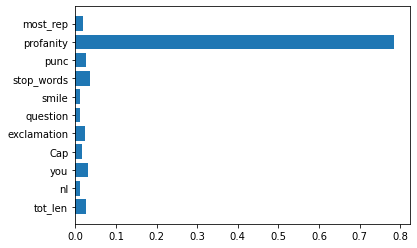

In [29]:
plt.barh(X_train.columns, xgb_best_clf.feature_importances_);

### | Permutation Importance 파악

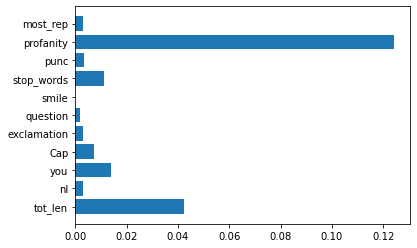

In [30]:
from sklearn.inspection import permutation_importance

sk_pi = permutation_importance(xgb_best_clf, X_train, y_train)
plt.barh(X_train.columns, sk_pi.importances_mean);